In [1]:
# !pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator
!pip install gdown
!pip install tensorflow-gpu

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [26]:
df = pd.read_csv(
  "/home/jovyan/work/training_data/rf_msw_training_data.csv", 
  parse_dates=['read_date'], 
  index_col="read_date"
)

In [27]:
df = df.drop(['bl_meter1','mean_temp1','bl_meter2','bl_ahd2','mean_temp2','bl_meter3','bl_ahd3','mean_temp3','bl_meter4','bl_ahd4','mean_temp4','sl_meter','rf_meter'
             ],axis=1)

In [28]:
df.shape

(5297, 3)

In [29]:
df.head()

,sl_read1,bl_ahd1,rf_read1
read_date,,,
2005-12-02,0.295,253.271,19.8
2005-12-03,0.303,253.277,21.4
2005-12-04,0.307,253.278,0.0
2005-12-05,0.303,253.275,0.0
2005-12-06,0.304,253.273,0.0


In [30]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

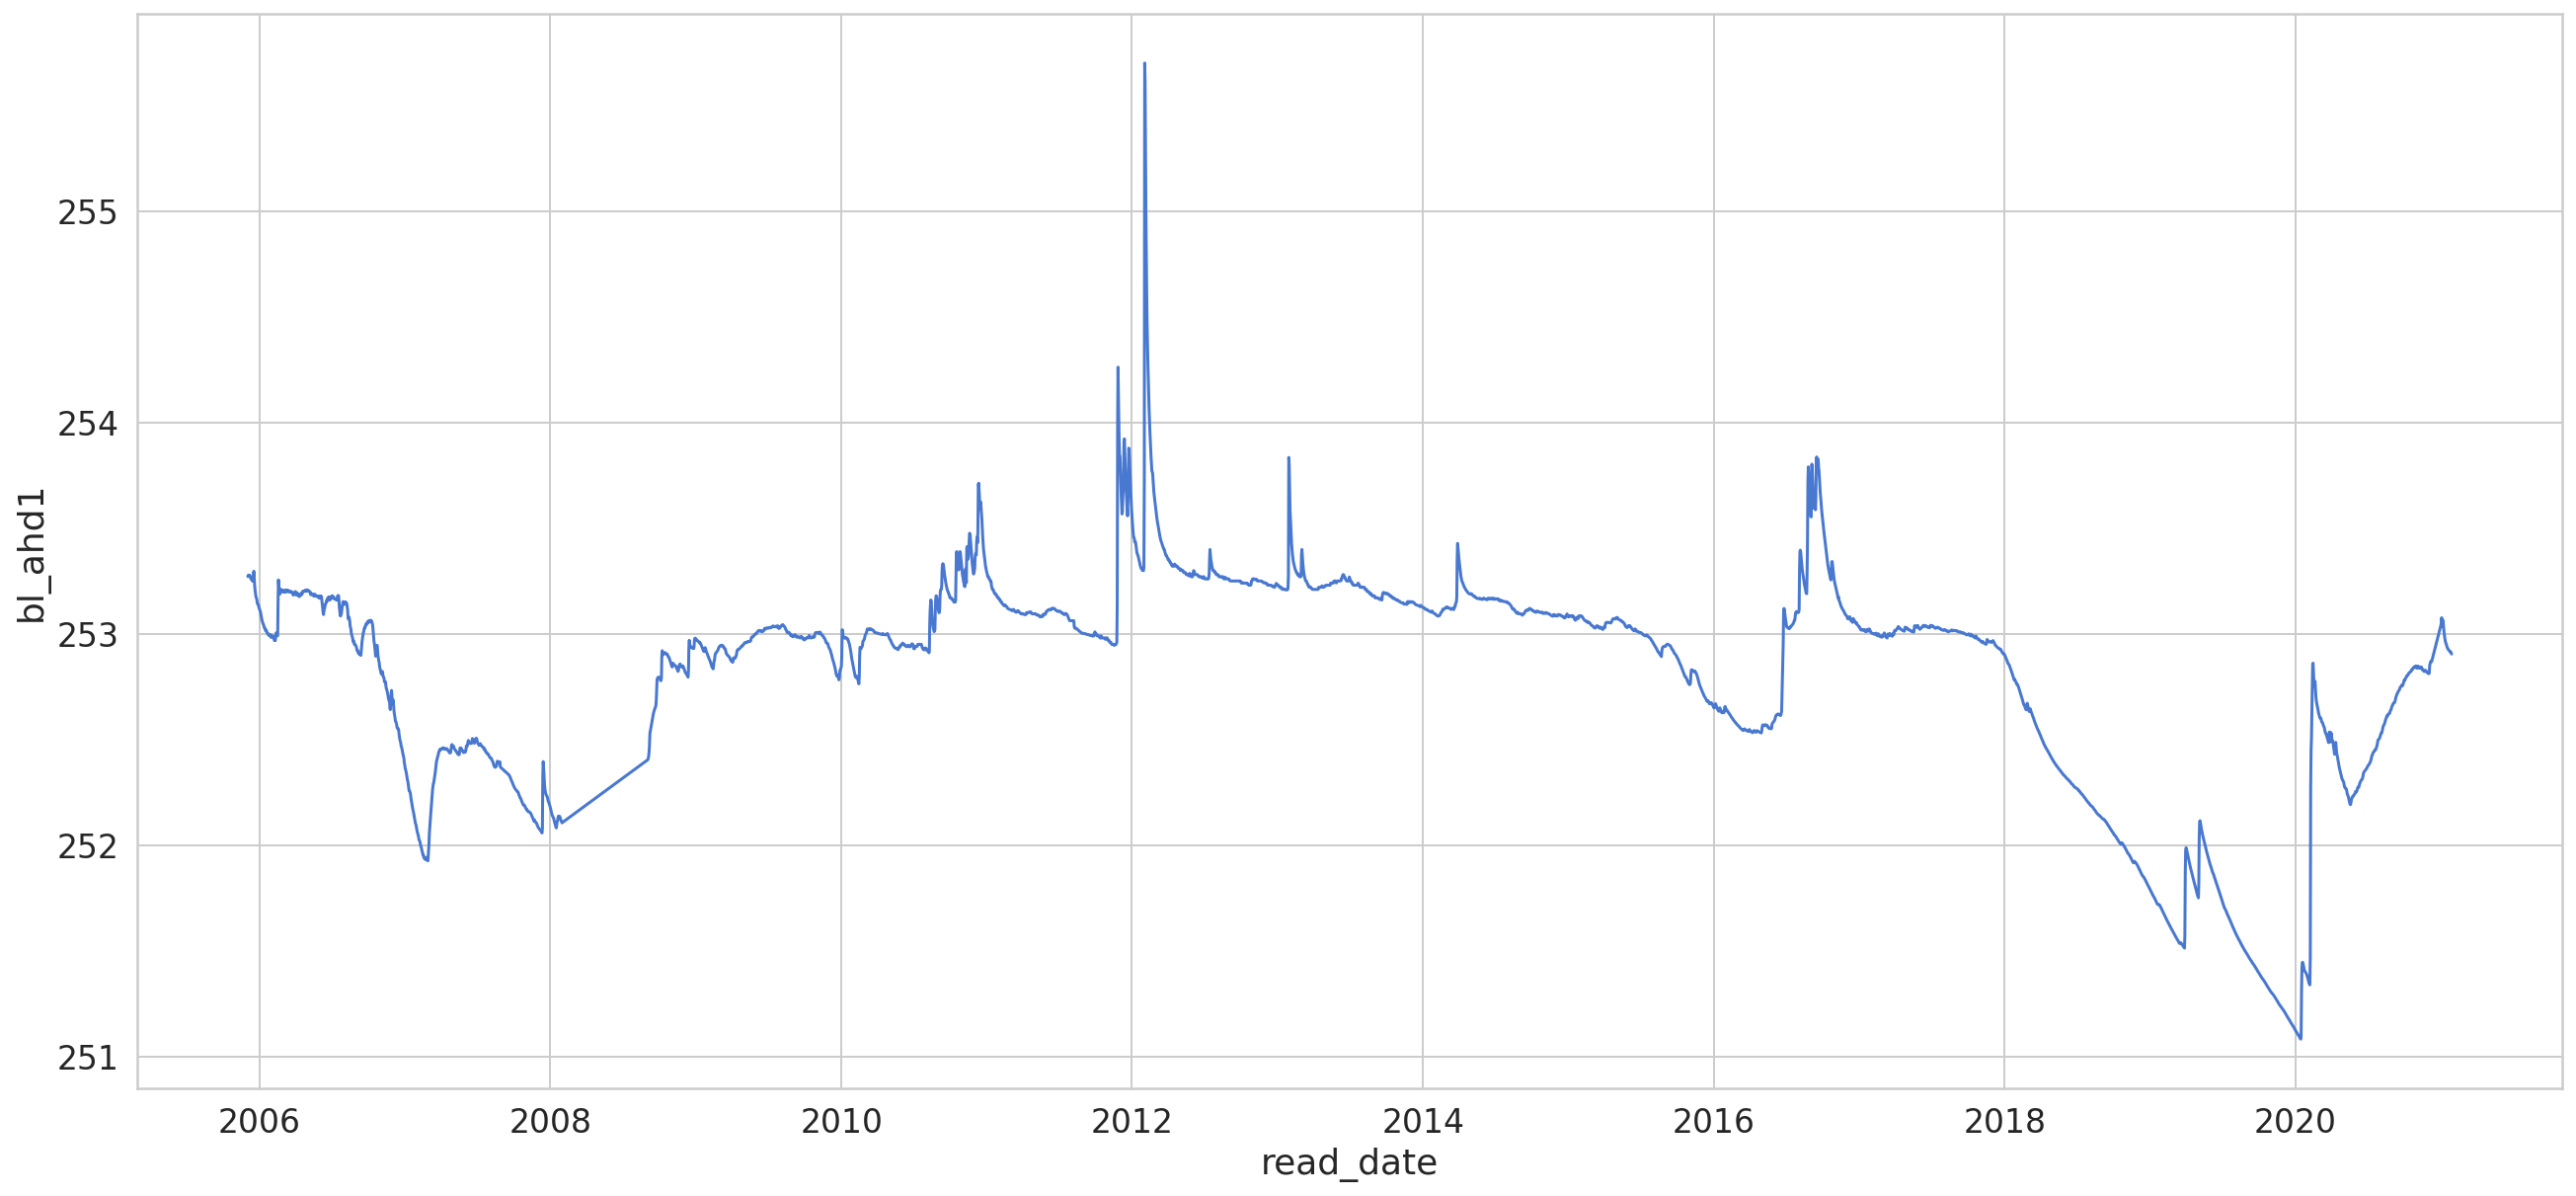

In [31]:
sns.lineplot(x=df.index, y="bl_ahd1", data=df);

In [33]:
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

3972 1325


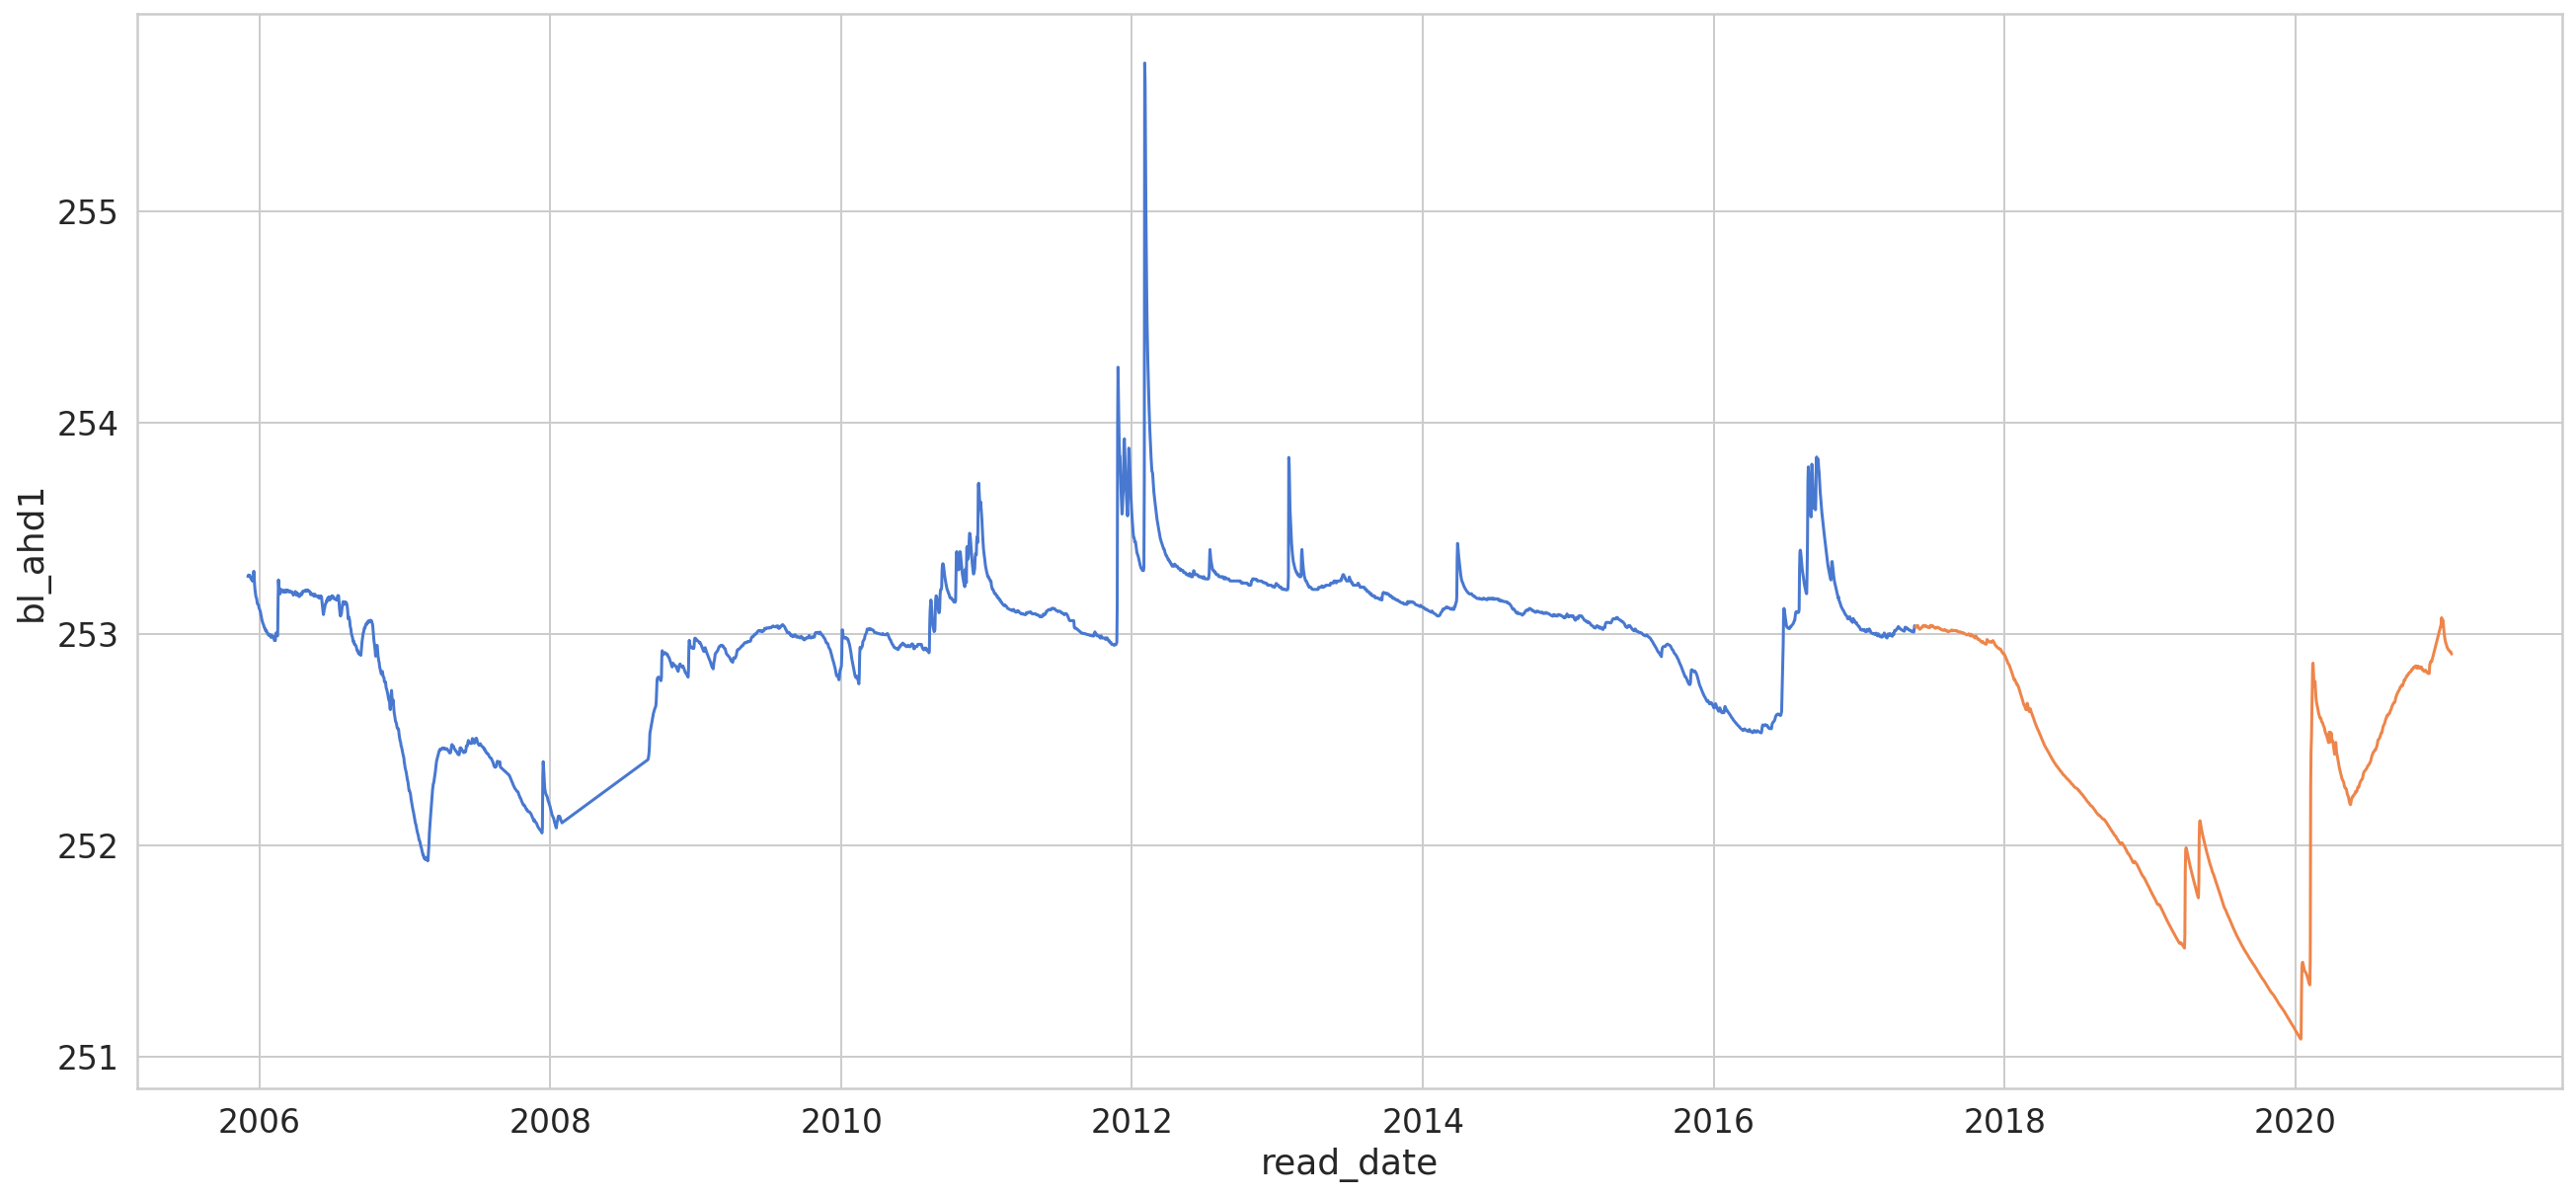

In [34]:
sns.lineplot(x=train.index, y="bl_ahd1", data=train);
sns.lineplot(x=test.index, y="bl_ahd1", data=test);

In [35]:
from sklearn.preprocessing import RobustScaler

#f_columns = ['t1', 't2', 'hum', 'wind_speed']
f_columns = ['rf_read1', 'sl_read1']

f_transformer = RobustScaler()
sl_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
sl_transformer = sl_transformer.fit(train[['bl_ahd1']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['bl_ahd1'] = sl_transformer.transform(train[['bl_ahd1']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['bl_ahd1'] = sl_transformer.transform(test[['bl_ahd1']])


#from sklearn.preprocessing import RobustScaler
#
#f_columns = ['t1', 't2', 'hum', 'wind_speed']
#
#f_transformer = RobustScaler()
#cnt_transformer = RobustScaler()
#
#f_transformer = f_transformer.fit(train[f_columns].to_numpy())
#cnt_transformer = cnt_transformer.fit(train[['cnt']])
#
#train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
#train['cnt'] = cnt_transformer.transform(train[['cnt']])
#
#test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
#test['cnt'] = cnt_transformer.transform(test[['cnt']])


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-35-76005faed3f1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bl_ahd1'] = sl_transformer.transform(train[['bl_ahd1']])
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [36]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [37]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.bl_ahd1, time_steps)
X_test, y_test = create_dataset(test, test.bl_ahd1, time_steps)

print(X_train.shape, y_train.shape)

(3962, 10, 7) (3962,)


In [38]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
history = model.fit(
    X_train, y_train, 
    epochs=40, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/40
112/112 [==============================] - 5s 19ms/step - loss: 1.2909 - val_loss: 0.3824
Epoch 2/40
112/112 [==============================] - 1s 13ms/step - loss: 1.1915 - val_loss: 0.2515
Epoch 3/40
112/112 [==============================] - 1s 12ms/step - loss: 0.8009 - val_loss: 0.1980
Epoch 4/40
112/112 [==============================] - 1s 12ms/step - loss: 0.5441 - val_loss: 0.1395
Epoch 5/40
112/112 [==============================] - 1s 13ms/step - loss: 0.3508 - val_loss: 0.0997
Epoch 6/40
112/112 [==============================] - 1s 13ms/step - loss: 0.2157 - val_loss: 0.0743
Epoch 7/40
112/112 [==============================] - 1s 13ms/step - loss: 0.1506 - val_loss: 0.0731
Epoch 8/40
112/112 [==============================] - 2s 14ms/step - loss: 0.1077 - val_loss: 0.0648
Epoch 9/40
112/112 [==============================] - 2s 14ms/step - loss: 0.1006 - val_loss: 0.0591
Epoch 10/40
112/112 [==============================] - 1s 13ms/step - loss: 0.0887 - val_lo

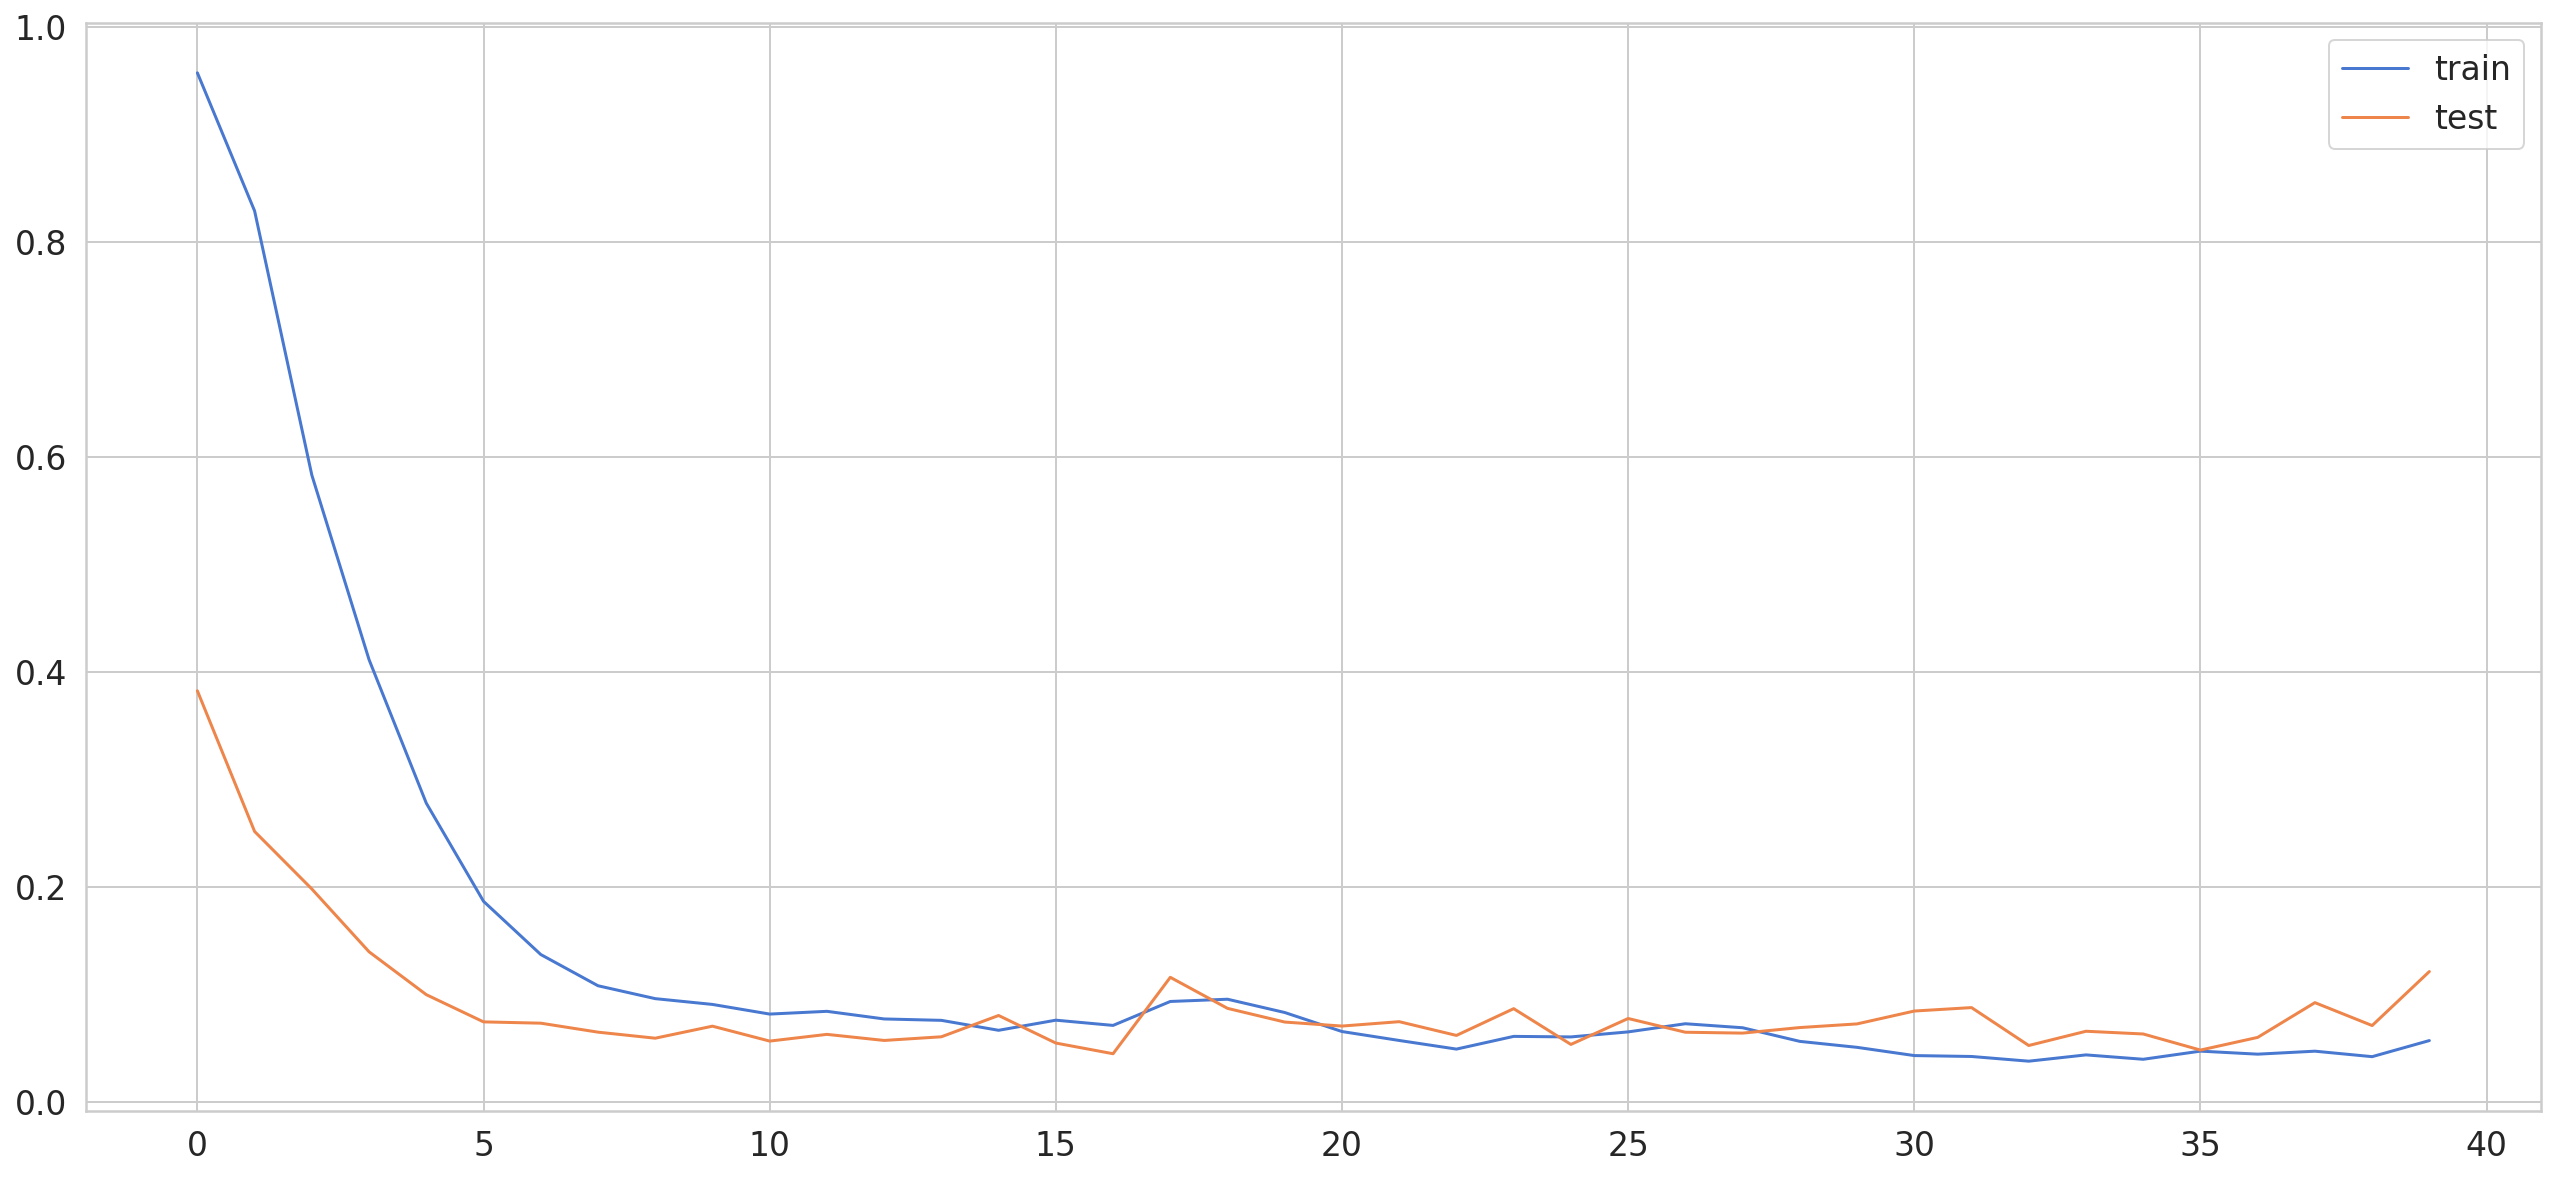

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [41]:
y_pred = model.predict(X_test)

In [42]:
y_train_inv = sl_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = sl_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = sl_transformer.inverse_transform(y_pred)

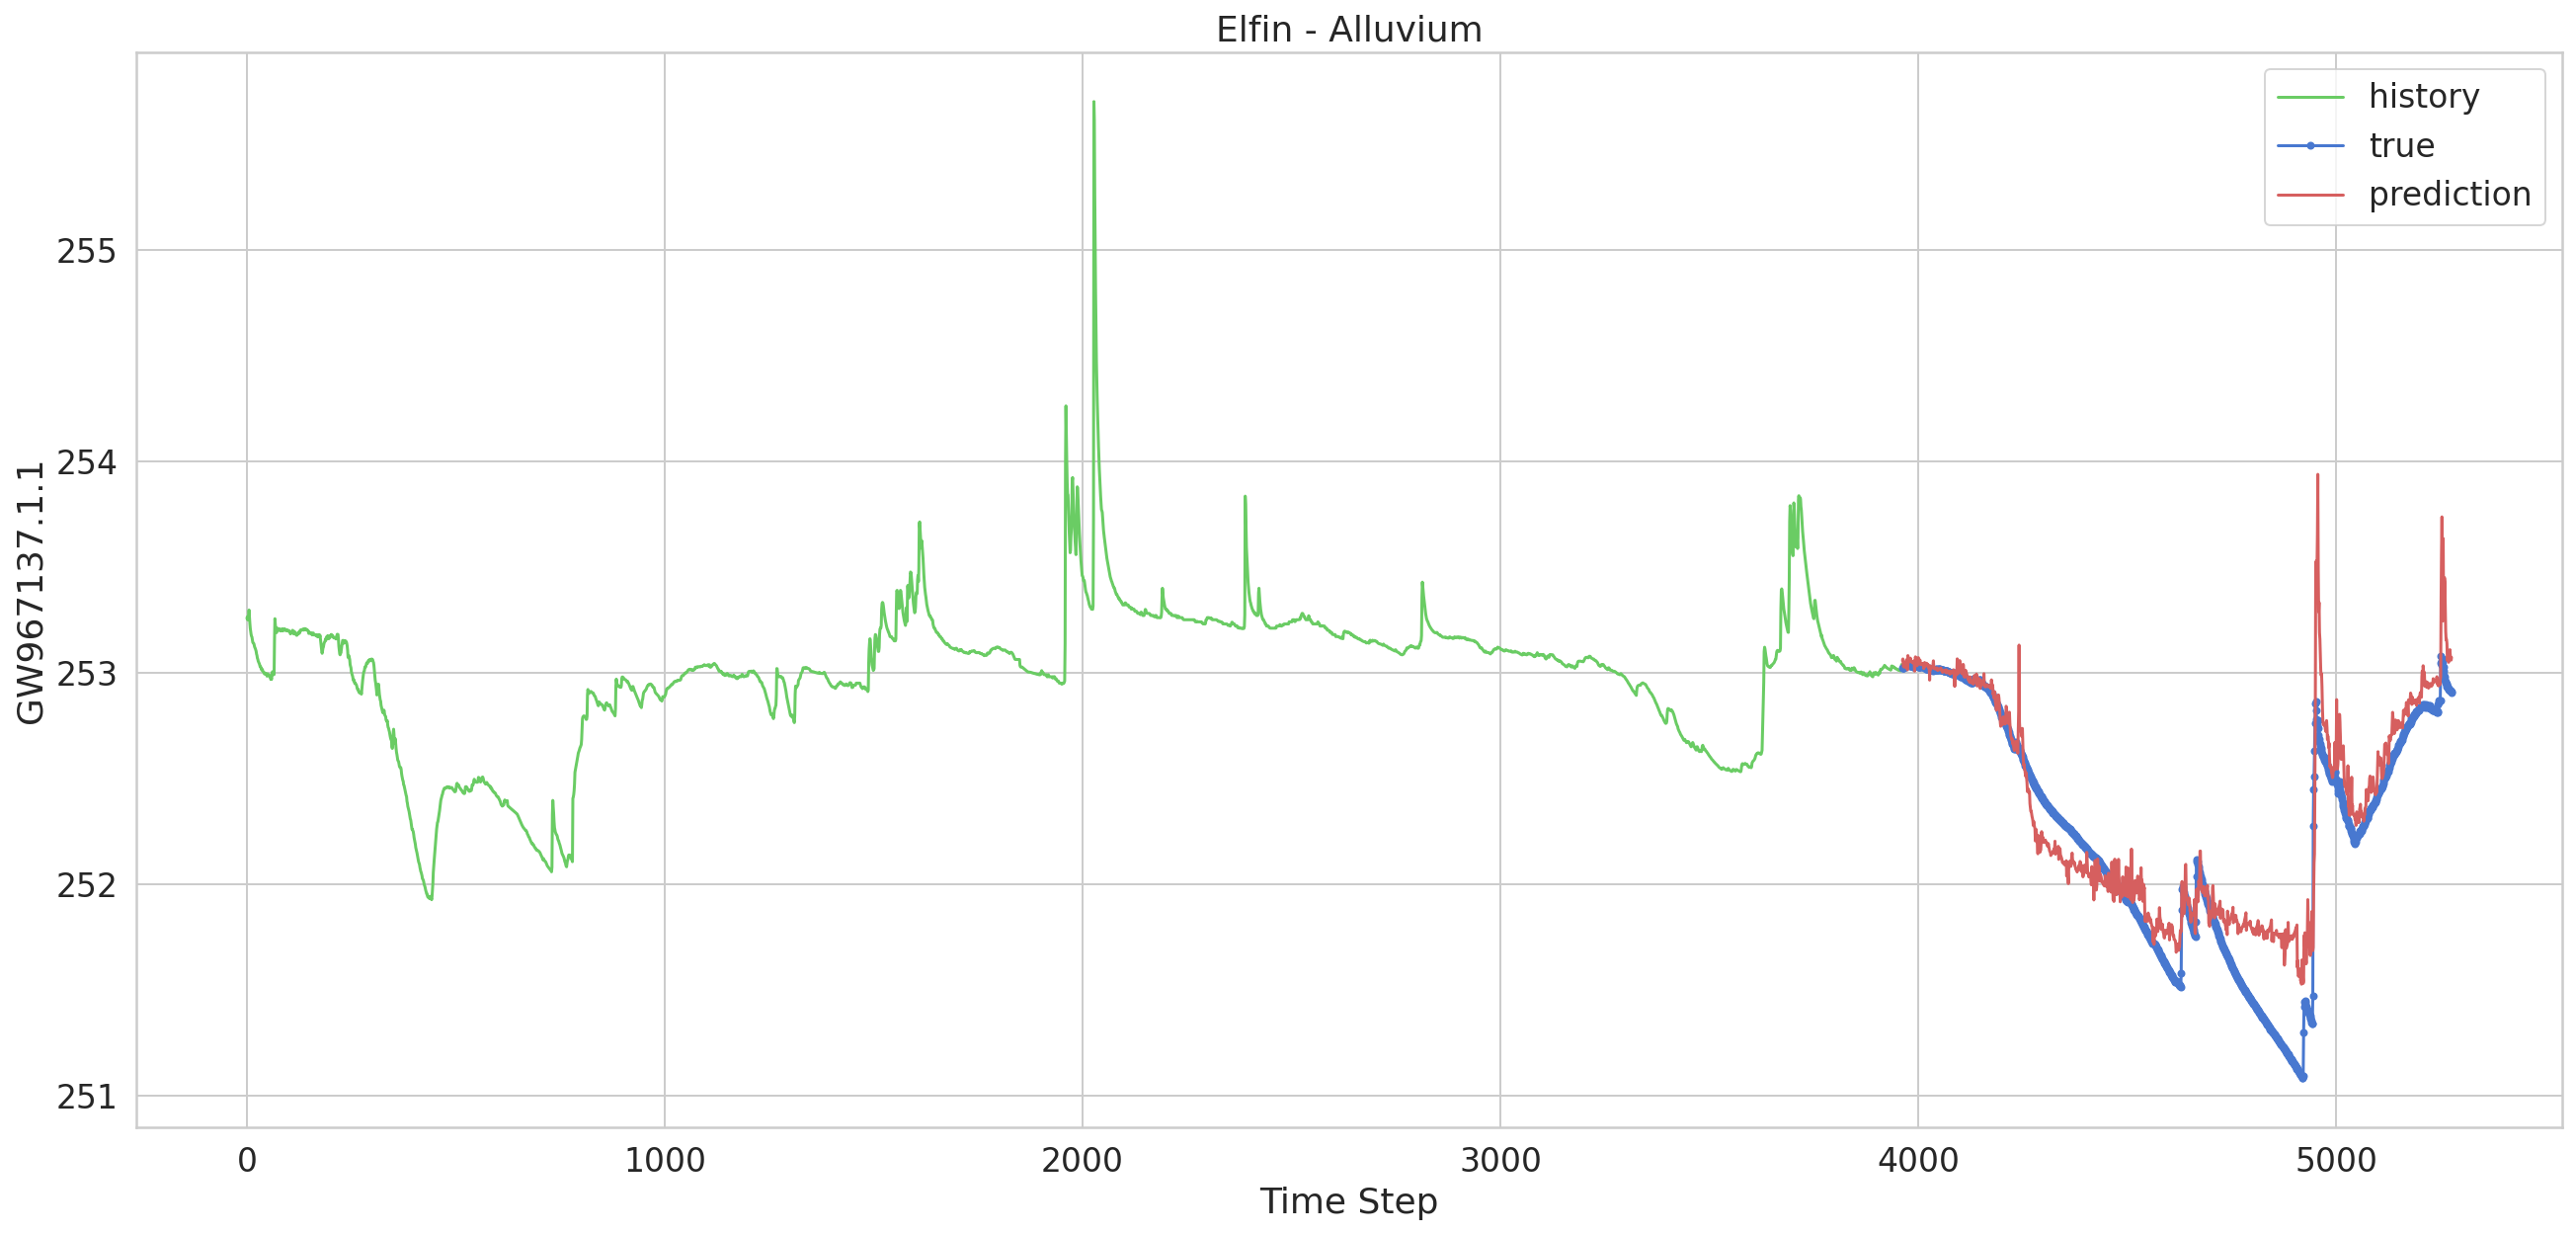

In [49]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('GW967137.1.1')
plt.xlabel('Time Step')
plt.title('Elfin - Alluvium')
plt.legend()
plt.show();

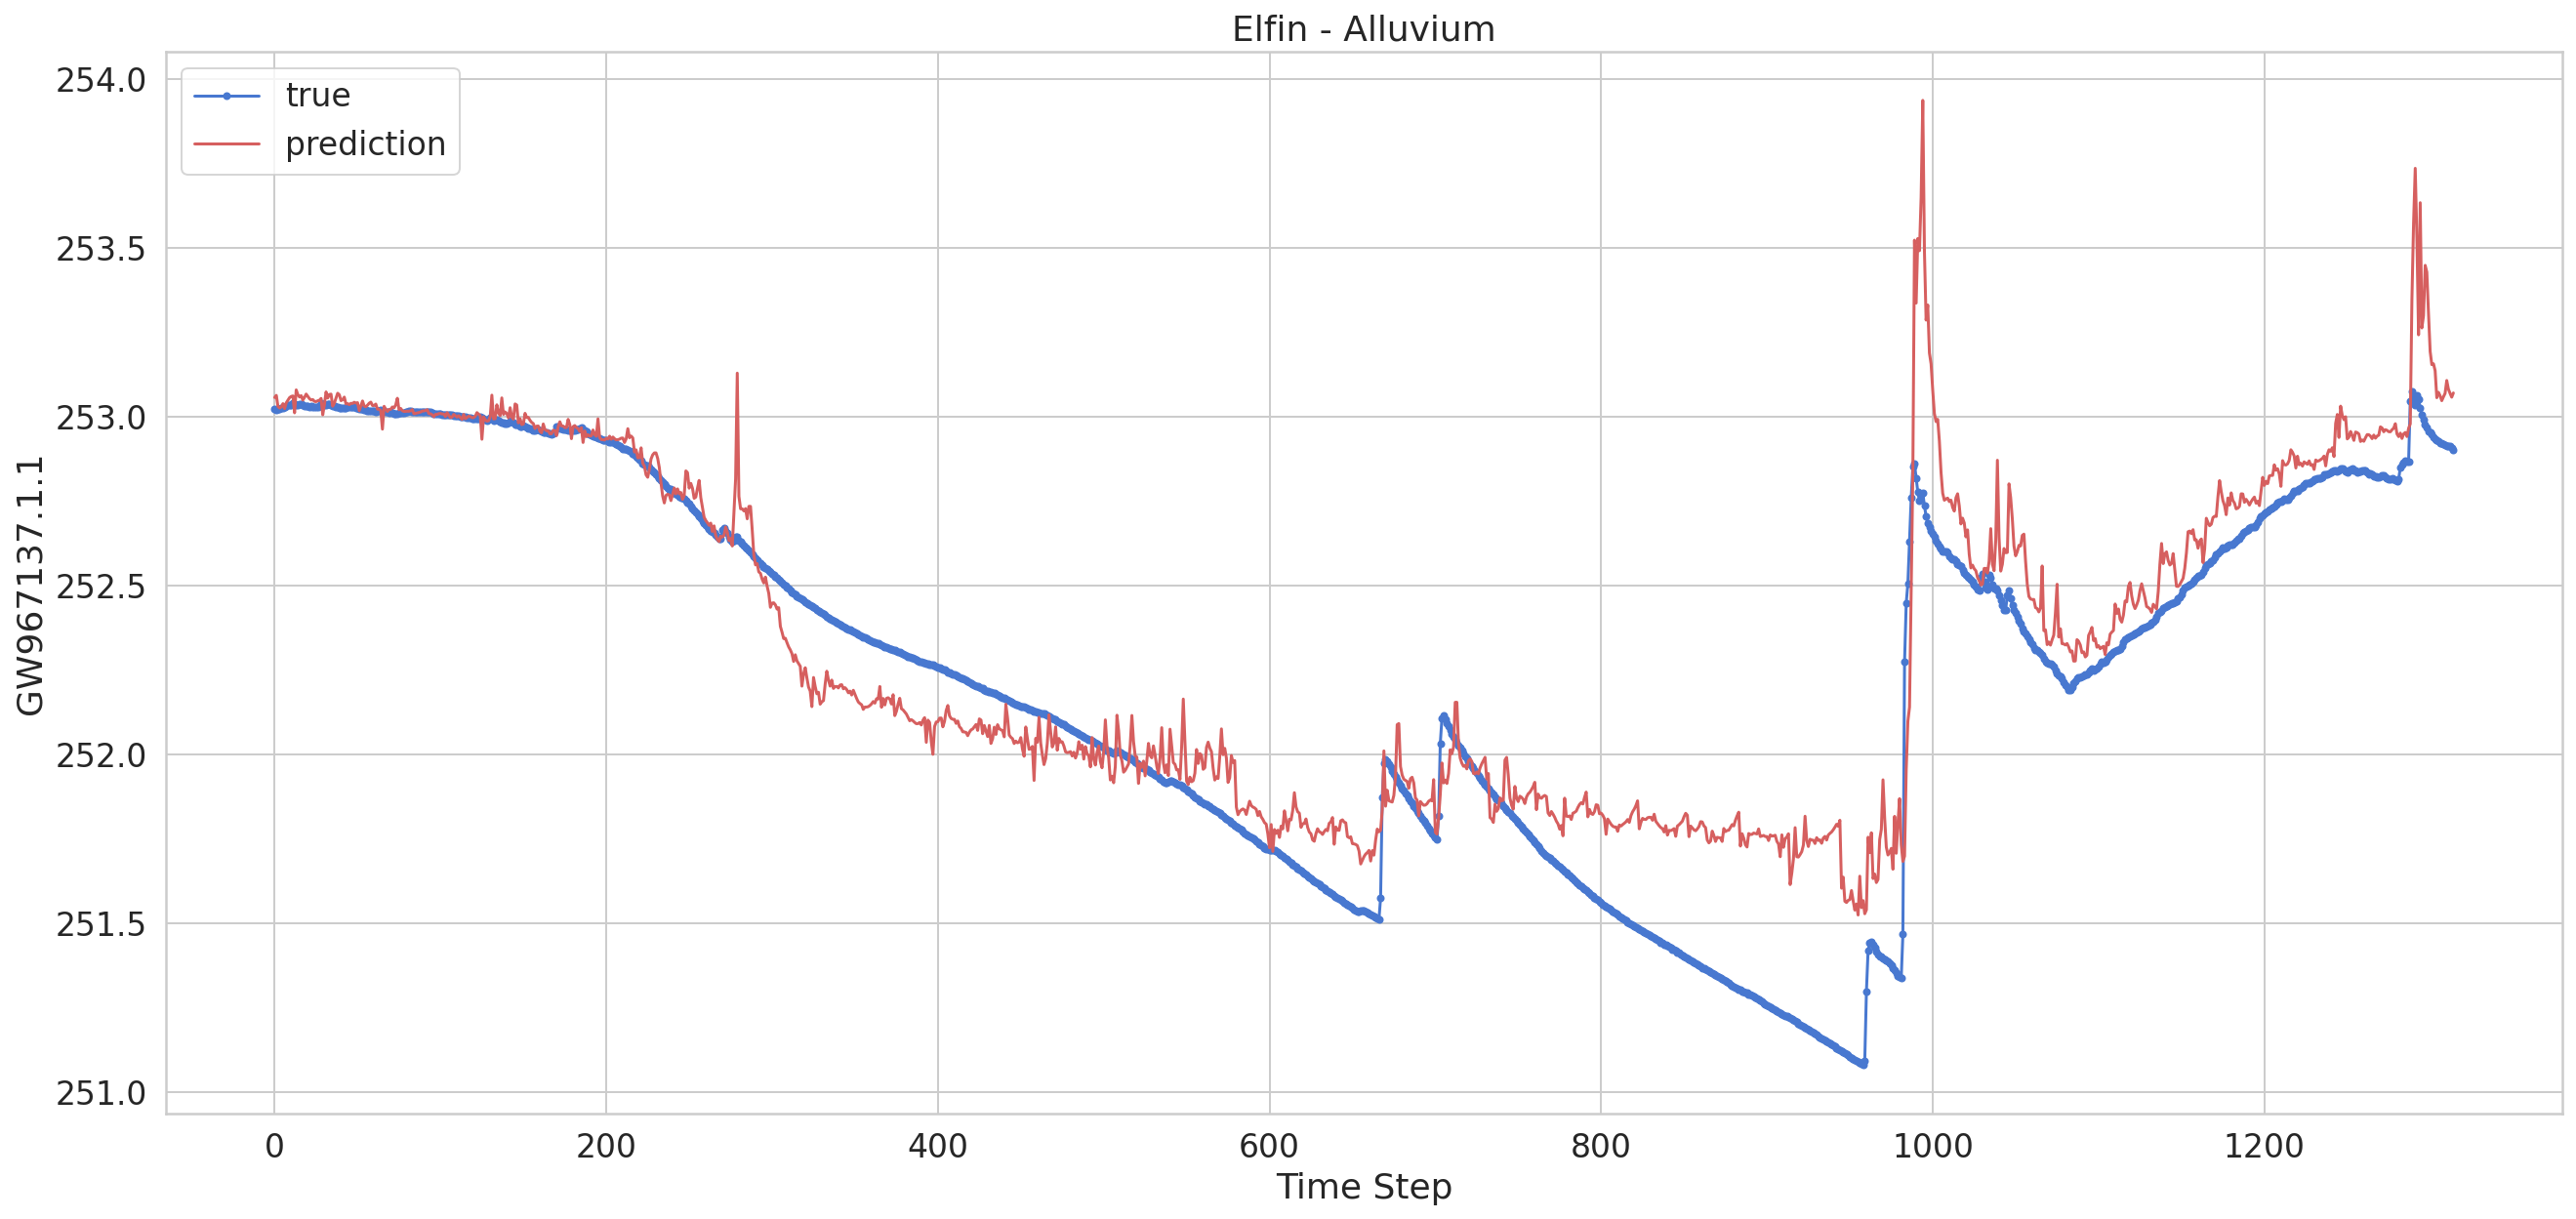

In [48]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('GW967137.1.1')
plt.xlabel('Time Step')
plt.title('Elfin - Alluvium')
plt.legend()
plt.show();

In [45]:
fname = '/home/jovyan/work/training_data/mal_modelled_training_data.csv'
np.savetxt(fname, y_pred_inv, fmt='%f', delimiter=' ', newline='\n', header='sf_read1', footer='', comments='', encoding=None)